# Data Preprocessing + Modelling

In [1]:
import os
import re
import h5py
import pickle

import evaluate

import numpy as np
import tensorflow as tf

np.random.seed(2021)
tf.random.set_seed(2021)

import pandas as pd
import keras
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss, confusion_matrix

import nltk
from nltk.stem.wordnet import WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
df = pd.read_csv('data/data_after_preprocessing.csv')

In [3]:
df['label'].value_counts()

0    7221
1    2017
Name: label, dtype: int64

## Text Preprocessing

In [4]:
# Remove punctuation
df['tweet'] = df['tweet'].str.replace('[^\w\s]','')
df['tweet'].head()

0    service connected covid19 pandemic impacting t...
1    im not gone lie ion like normal girls i like e...
2    content warnings for billies documentary  stro...
3    why am i helping my suicidal irl im literally ...
4    the polluter pays principle is a threat to thi...
Name: tweet, dtype: object

In [5]:
# Lemmatization
nltk.download('wordnet')

df['tweet'] = df['tweet'].apply(lambda x:' '.join(WordNetLemmatizer().lemmatize(i) for i in x.split(' ')))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
df['tweet'].head()

0    service connected covid19 pandemic impacting t...
1    im not gone lie ion like normal girl i like em...
2    content warning for billy documentary  strong ...
3    why am i helping my suicidal irl im literally ...
4    the polluter pay principle is a threat to this...
Name: tweet, dtype: object

In [7]:
df.dtypes

tweet              object
label               int64
day                 int64
nlikes              int64
nreplies            int64
nretweets           int64
reply_to            int64
url                 int64
join_time           int64
tweets              int64
following           int64
followers           int64
likes               int64
media               int64
day_after           int64
tweet_length        int64
tweet_sentiment     int64
bio_sentiment       int64
first_person        int64
second_person       int64
third_person        int64
dtype: object

### Train test split

In [8]:
data_y = df['label']
data_x = df['tweet']

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, stratify=data_y, random_state = 2021)

In [9]:
x_train.apply(lambda x : len(x.split(' '))).quantile(0.95)

53.0

### Tokenizer

In [10]:
# Run keras Tokenizer
# Tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(x_train)
x_train_tok = tokenizer.texts_to_sequences(x_train)
x_test_tok = tokenizer.texts_to_sequences(x_test)

In [11]:
import pickle

with open('LSTM_models/tokenizer.pkl','wb') as f:
    pickle.dump(tokenizer,f)

### Pad sequences

In [12]:
#training constants
MAX_SEQ_LEN = 53 # Based on above

In [13]:
train_text_vec = pad_sequences(x_train_tok, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(x_test_tok, maxlen=MAX_SEQ_LEN)

In [14]:
print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", train_text_vec.max(), "\n")

print('Sample Tweet Before Processing:', x_train.values[0])
print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[0]]), '\n')

print('What the model will interpret:', train_text_vec[0].tolist())

Number of Tokens: 14216
Max Token Index: 14216 

Sample Tweet Before Processing: we can at least prevent people from such suicidal act  using coronil remains their choice eventually marne ke baad coronil kaam ka nahi bol ke kya fayda
Sample Tweet After Processing: ['we can at least prevent people from such suicidal act using coronil remains their choice eventually marne ke baad coronil kaam ka nahi bol ke kya fayda'] 

What the model will interpret: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 45, 43, 358, 788, 27, 42, 296, 1, 372, 470, 2691, 2146, 79, 768, 1153, 4575, 1957, 4576, 2691, 4577, 1958, 3629, 4578, 1957, 4579, 4580]


In [15]:
# One Hot Encode Y values:
encoder = LabelEncoder()

y_train_label = encoder.fit_transform(y_train.values)
y_train_label = to_categorical(y_train_label) 

y_test_label = encoder.fit_transform(y_test.values)
y_test_label = to_categorical(y_test_label) 

### Get class weights for the training data, this will be used in training

In [16]:
from collections import Counter

ctr = Counter(y_train.values)
print('Distribution of Classes:', ctr)

Distribution of Classes: Counter({0: 5776, 1: 1614})


In [17]:
# get class weights for the training data, this will be used data
y_train_int = np.argmax(y_train_label,axis=1)
cws_raw = class_weight.compute_class_weight('balanced', np.unique(y_train_int), y_train_int)
label = [0,1]

cws = dict(zip(label, cws_raw))

print(cws)

{0: 0.6397160664819944, 1: 2.2893432465923174}


C:\Users\OVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


## Modelling

### Bidirectional LSTM

In [30]:
DEFAULT_BATCH_SIZE = 64
DEFAULT_EPOCHS = 100

model = Sequential()
model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer = 'adam',
              loss = keras.losses.BinaryCrossentropy(from_logits = False),
              metrics = ['accuracy']
             )

early_stop = keras.callbacks.EarlyStopping(monitor = 'loss',
                                              verbose = 1,
                                              patience = 10,
                                              mode = 'auto',
                                              restore_best_weights = True
                                             )

checkpoint = ModelCheckpoint('LSTM_models/best_LSTM_model.h5', monitor='loss', mode='auto', 
                             verbose = 1, save_best_only=True)

callbacks_list = [checkpoint, early_stop]

model.fit(x=train_text_vec,
          y=y_train_label,
          class_weight=cws,
          batch_size=DEFAULT_BATCH_SIZE,
          epochs=DEFAULT_EPOCHS,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(
              test_text_vec,
              y_test_label,
          ))

Epoch 1/100
116/116 [==============================] - 53s 414ms/step - loss: 0.6398 - accuracy: 0.5507 - val_loss: 0.4279 - val_accuracy: 0.8117

Epoch 00001: loss improved from inf to 0.56624, saving model to LSTM_models\best_LSTM_model.h5
Epoch 2/100
116/116 [==============================] - 53s 461ms/step - loss: 0.3855 - accuracy: 0.8225 - val_loss: 0.4150 - val_accuracy: 0.8209

Epoch 00002: loss improved from 0.56624 to 0.38841, saving model to LSTM_models\best_LSTM_model.h5
Epoch 3/100
116/116 [==============================] - 53s 457ms/step - loss: 0.2898 - accuracy: 0.8736 - val_loss: 0.4010 - val_accuracy: 0.8144

Epoch 00003: loss improved from 0.38841 to 0.29063, saving model to LSTM_models\best_LSTM_model.h5
Epoch 4/100
116/116 [==============================] - 53s 457ms/step - loss: 0.2130 - accuracy: 0.9054 - val_loss: 0.4754 - val_accuracy: 0.7938

Epoch 00004: loss improved from 0.29063 to 0.20948, saving model to LSTM_models\best_LSTM_model.h5
Epoch 5/100
116/116 

116/116 [==============================] - 59s 505ms/step - loss: 0.0175 - accuracy: 0.9913 - val_loss: 1.2356 - val_accuracy: 0.7992

Epoch 00037: loss did not improve from 0.01192
Epoch 38/100
116/116 [==============================] - 58s 501ms/step - loss: 0.0122 - accuracy: 0.9948 - val_loss: 1.2768 - val_accuracy: 0.7500

Epoch 00038: loss did not improve from 0.01192
Epoch 39/100
116/116 [==============================] - 59s 507ms/step - loss: 0.0408 - accuracy: 0.9842 - val_loss: 0.9510 - val_accuracy: 0.7873

Epoch 00039: loss did not improve from 0.01192
Epoch 40/100
116/116 [==============================] - 62s 534ms/step - loss: 0.0234 - accuracy: 0.9894 - val_loss: 1.3178 - val_accuracy: 0.7911

Epoch 00040: loss did not improve from 0.01192
Epoch 41/100
116/116 [==============================] - 58s 499ms/step - loss: 0.0117 - accuracy: 0.9959 - val_loss: 1.2172 - val_accuracy: 0.7781

Epoch 00041: loss did not improve from 0.01192
Epoch 42/100
116/116 [================

116/116 [==============================] - 59s 507ms/step - loss: 0.0151 - accuracy: 0.9927 - val_loss: 1.3715 - val_accuracy: 0.7830

Epoch 00077: loss did not improve from 0.00563
Epoch 78/100
116/116 [==============================] - 59s 504ms/step - loss: 0.0108 - accuracy: 0.9951 - val_loss: 1.4778 - val_accuracy: 0.7884

Epoch 00078: loss did not improve from 0.00563
Epoch 79/100
116/116 [==============================] - 59s 506ms/step - loss: 0.0068 - accuracy: 0.9969 - val_loss: 1.6672 - val_accuracy: 0.7819

Epoch 00079: loss did not improve from 0.00563
Epoch 80/100
116/116 [==============================] - 59s 505ms/step - loss: 0.0045 - accuracy: 0.9968 - val_loss: 1.6127 - val_accuracy: 0.7998

Epoch 00080: loss did not improve from 0.00563
Epoch 81/100
116/116 [==============================] - 63s 540ms/step - loss: 0.0060 - accuracy: 0.9963 - val_loss: 1.6913 - val_accuracy: 0.7987

Epoch 00081: loss did not improve from 0.00563
Restoring model weights from the end o

In [31]:
model.load_weights('LSTM_models/best_LSTM_model.h5')

y_test_hat = model.predict(test_text_vec)
confusion = confusion_matrix(np.argmax(y_test_label,axis=1), np.argmax(y_test_hat,axis=1))
class_report = classification_report(np.argmax(y_test_label, axis=1), np.argmax(y_test_hat, axis=1))
                                     
print("Confusion matrix:\n", confusion)
print("\n")
print("Classification report:\n",class_report)

perf_metrics = evaluate.performance(y_test, np.argmax(y_test_hat,axis=1), y_test_hat)
print(perf_metrics['report'])

threshold_metrics = evaluate.threshold(y_test_hat, y_test)
print(threshold_metrics)

Confusion matrix:
 [[1246  199]
 [ 176  227]]


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1445
           1       0.53      0.56      0.55       403

    accuracy                           0.80      1848
   macro avg       0.70      0.71      0.71      1848
weighted avg       0.80      0.80      0.80      1848


The evaluation report of classification is:
Confusion Matrix:
[[1246  199]
 [ 176  227]]
Accuracy: 0.797077922077922
Precision: 0.5328638497652582
Recall: 0.5632754342431762
F2 Score: 0.5569185475956819
AUC Score: 0.8074493204083562

{'threshold': 0.01, 'score': 0.6023255813953488, 'y_pred': array([0, 0, 0, ..., 1, 0, 0])}


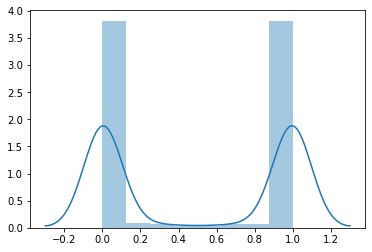

In [32]:
import seaborn as sns

sns.distplot(y_test_hat)

### Bidirectional LSTM with CNN layer

In [27]:
DEFAULT_BATCH_SIZE = 64
DEFAULT_EPOCHS = 100

model_cnn = Sequential()
model_cnn.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
model_cnn.add(SpatialDropout1D(0.2))
model_cnn.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_cnn.add(Conv1D(64, 4))
model_cnn.add(GlobalMaxPool1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(2, activation='sigmoid'))


model_cnn.compile(optimizer = 'adam', 
              loss=keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=['accuracy'])

early_stop_cnn = keras.callbacks.EarlyStopping(monitor = 'loss',
                                                  verbose = 1,
                                                  patience = 10,
                                                  mode = 'auto',
                                                  restore_best_weights = True
                                                 )

checkpoint_cnn = ModelCheckpoint('LSTM_models/best_LSTM_CNN_model.h5', monitor='loss', mode='auto', 
                             verbose = 1, save_best_only=True)

callbacks_list_cnn = [checkpoint_cnn, early_stop_cnn]

model_cnn.fit(x=train_text_vec,
              y=y_train_label,
              class_weight=cws,
              batch_size=DEFAULT_BATCH_SIZE,
              epochs=DEFAULT_EPOCHS,
              callbacks=callbacks_list_cnn,
              verbose=1,
              validation_data=(
                  test_text_vec,
                  y_test_label
              ))

Epoch 1/100
116/116 [==============================] - 53s 416ms/step - loss: 0.6247 - accuracy: 0.5894 - val_loss: 0.3894 - val_accuracy: 0.8247

Epoch 00001: loss improved from inf to 0.54548, saving model to LSTM_models\best_LSTM_CNN_model.h5
Epoch 2/100
116/116 [==============================] - 60s 520ms/step - loss: 0.3498 - accuracy: 0.8418 - val_loss: 0.3928 - val_accuracy: 0.8312

Epoch 00002: loss improved from 0.54548 to 0.35497, saving model to LSTM_models\best_LSTM_CNN_model.h5
Epoch 3/100
116/116 [==============================] - 61s 530ms/step - loss: 0.2451 - accuracy: 0.8983 - val_loss: 0.4788 - val_accuracy: 0.7998

Epoch 00003: loss improved from 0.35497 to 0.24929, saving model to LSTM_models\best_LSTM_CNN_model.h5
Epoch 4/100
116/116 [==============================] - 62s 532ms/step - loss: 0.1785 - accuracy: 0.9142 - val_loss: 0.5843 - val_accuracy: 0.8133

Epoch 00004: loss improved from 0.24929 to 0.17787, saving model to LSTM_models\best_LSTM_CNN_model.h5
Epoc

116/116 [==============================] - 69s 596ms/step - loss: 0.0062 - accuracy: 0.9970 - val_loss: 2.1080 - val_accuracy: 0.8106

Epoch 00037: loss did not improve from 0.00858
Epoch 38/100
116/116 [==============================] - 74s 634ms/step - loss: 0.0086 - accuracy: 0.9966 - val_loss: 1.8578 - val_accuracy: 0.8041

Epoch 00038: loss did not improve from 0.00858
Epoch 39/100
116/116 [==============================] - 70s 603ms/step - loss: 0.0081 - accuracy: 0.9955 - val_loss: 2.4763 - val_accuracy: 0.7321

Epoch 00039: loss improved from 0.00858 to 0.00747, saving model to LSTM_models\best_LSTM_CNN_model.h5
Epoch 40/100
116/116 [==============================] - 69s 593ms/step - loss: 0.0349 - accuracy: 0.9880 - val_loss: 1.4621 - val_accuracy: 0.7808

Epoch 00040: loss did not improve from 0.00747
Epoch 41/100
116/116 [==============================] - 69s 594ms/step - loss: 0.0136 - accuracy: 0.9931 - val_loss: 1.4540 - val_accuracy: 0.8019

Epoch 00041: loss did not imp

In [28]:
model_cnn.load_weights('LSTM_models/best_LSTM_CNN_model.h5')

y_test_hat_cnn = model_cnn.predict(test_text_vec)
confusion_cnn = confusion_matrix(np.argmax(y_test_label,axis=1), np.argmax(y_test_hat_cnn,axis=1))
class_report_cnn = classification_report(np.argmax(y_test_label, axis=1), np.argmax(y_test_hat_cnn, axis=1))
                                     
print("Confusion matrix:\n", confusion_cnn)
print("\n")
print("Classification report:\n",class_report_cnn)

perf_metrics_cnn = evaluate.performance(y_test, np.argmax(y_test_hat_cnn,axis=1), y_test_hat_cnn)
print(perf_metrics_cnn['report'])

threshold_metrics_cnn = evaluate.threshold(y_test_hat_cnn, y_test)
print(threshold_metrics_cnn)

Confusion matrix:
 [[1045  400]
 [  95  308]]


Classification report:
               precision    recall  f1-score   support

           0       0.92      0.72      0.81      1445
           1       0.44      0.76      0.55       403

    accuracy                           0.73      1848
   macro avg       0.68      0.74      0.68      1848
weighted avg       0.81      0.73      0.75      1848


The evaluation report of classification is:
Confusion Matrix:
[[1045  400]
 [  95  308]]
Accuracy: 0.7321428571428571
Precision: 0.4350282485875706
Recall: 0.7642679900744417
F2 Score: 0.6637931034482758
AUC Score: 0.8174452849304954

{'threshold': 0.03, 'score': 0.6939868204283361, 'y_pred': array([1, 0, 0, ..., 0, 0, 0])}


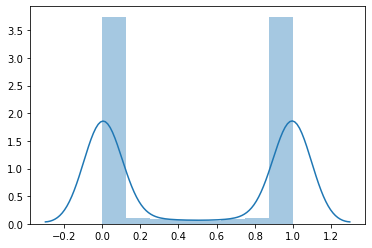

In [29]:
import seaborn as sns

sns.distplot(y_test_hat_cnn)